In [1]:
from __future__ import annotations

from typing import Callable

In [2]:
import torch as tch
from torch import nn
from torch.nn import functional as F
import numpy as np

In [3]:
dev = tch.device("cuda:0")

In [4]:
from dataclasses import dataclass


@dataclass
class Rays:
    pos: tch.Tensor  # shape: (B, 3)
    dir: tch.Tensor  # shape: (B, 3)

    def advance(self, step: float | tch.Tensor) -> Rays:
        return Rays(self.pos + self.dir * step, self.dir)

    @property
    def device(self) -> tch.device:
        return self.pos.device


@dataclass
class Radiance:
    color: tch.Tensor  # shape: (B, 3)
    density: tch.Tensor  # shape: (B, 1)

    @staticmethod
    def zero(bs: int, dev: tch.device) -> Radiance:
        return Radiance(tch.zeros((bs, 3), device=dev), tch.zeros((bs, 1), device=dev))

    def blend(self, add: Radiance, step: float | tch.Tensor) -> Radiance:
        new_density = self.density + add.density * step
        new_color = self.color + add.color * add.density * tch.exp(-new_density) * step
        return Radiance(new_color, new_density)

In [5]:
def raymarch(
    func: Callable[[Rays], Radiance],
    init_rays: Rays,
    step_size: float | tuple[float, float],
    num_steps: int,
) -> Radiance:
    bs = init_rays.pos.shape[0]
    dev = init_rays.device

    distances = tch.zeros((bs, 1), device=dev)
    total_radiance = Radiance.zero(bs, dev)
    for i in range(num_steps):
        rays = init_rays.advance(distances)

        radiance = func(rays)

        if isinstance(step_size, float):
            step = step_size
        else:
            step = step_size[0] + (step_size[1] - step_size[0]) * tch.rand(
                (bs, 1), device=dev
            )
        distances += step

        total_radiance = total_radiance.blend(radiance, step)

    return total_radiance


In [6]:
@dataclass
class Camera:
    angles: tuple[float, float] = (np.pi / 2, np.pi / 2)
    offset: tuple[float, float] = (0.0, 0.0)

In [7]:
from nerfpg import grid


def pad_right(t: tch.Tensor, value: float, count: int = 1) -> tch.Tensor:
    return tch.cat(
        [t, tch.tensor(value, device=t.device).broadcast_to((*t.shape[:-1], count))],
        dim=-1,
    )


def rays_proj(
    coords: tch.Tensor,
    transform: list[list[float]],
    camera: Camera,
) -> Rays:
    """
    coords shape: (B, 2) where coordinates are in a range from 0.0 to 1.0
    """
    dev = coords.device
    bs = coords.shape[0]

    matrix = tch.tensor(transform, device=dev)

    dxy = (2.0 * coords - 1.0) * tch.tensor([1.0, -1.0], device=dev).unsqueeze(0)
    dxy = dxy - tch.tensor(camera.offset, device=dev)
    dxy = dxy * (tch.tensor(camera.angles, device=dev) / 2.0).tan()

    dir = pad_right(dxy, -1.0)
    dir = dir / dir.pow(2).sum(dim=-1, keepdim=True)  # normalize direction vectors
    dir = tch.einsum("bi,ji->bj", dir, matrix[:3, :3])

    pos = matrix[:3, 3].reshape((1, 3)).broadcast_to((bs, 3))
    return Rays(pos, dir)


def rays_grid(
    shape: tuple[int, int],
    dev: tch.device,
    transform: list[list[float]],
    camera: Camera,
) -> Rays:
    return rays_proj(grid(shape, dev).transpose(0, 1).flatten(0, 1), transform, camera)

In [8]:
from nerfpg import tensor_to_image, image_to_tensor


def infer(
    model: Callable[[Rays], Radiance],
    res: tuple[int, int],
    dev: tch.device,
    transform: list[list[float]],
    camera: Camera,
    step_size: float,
    max_distance: float,
) -> Image:
    rays = rays_grid(res, dev, transform, camera)
    ys = raymarch(model, rays, step_size, int(max_distance / step_size))
    out = ys.color.transpose(0, 1).reshape((-1, res[1], res[0]))
    return tensor_to_image(out)

In [9]:
def dummy(rays: Rays) -> Radiance:
    density = 1.0 - rays.pos.pow(2).sum(dim=-1, keepdim=True)
    density += 0.4 * tch.cos(8.0 * rays.pos).sum(dim=-1, keepdim=True)
    density *= 10.0
    density = density.exp()

    color = rays.pos.abs().clamp(0.0, 1.0)
    return Radiance(color, density)

In [10]:
from math import sin, cos


def make_transform(distance: float, angle: float) -> list[list[float]]:
    return [
        [cos(angle), 0.0, -sin(angle), -distance * sin(angle)],
        [-sin(angle), 0.0, -cos(angle), -distance * cos(angle)],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ]

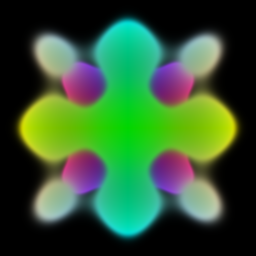

In [11]:
res = (256, 256)
distance = 2.0
step_size = 0.01
infer(
    dummy,
    res,
    dev,
    transform=make_transform(distance, 0.0),
    camera=Camera(),
    max_distance=2.0 * distance,
    step_size=step_size,
)

In [12]:
from dataclasses import dataclass
from PIL import Image


@dataclass
class Frame:
    image: Image
    matrix: list[list[float]]
    _tensor: tch.Tensor | None = None
    # TODO: Cache matrix

    def image_tensor(self, dev: tch.device) -> tch.Tensor:
        if self._tensor is None:
            self._tensor = image_to_tensor(self.image, dev)
        return self._tensor


In [13]:
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
from tqdm import tqdm
from IPython.display import Video


def make_video_frames(
    model: Callable[[Rays], Radiance],
    dev: tch.device,
    n_frames: int,
    res: tuple[int, int],
    distance: float,
    step_size: float = 0.01,
) -> list[Frame]:
    frames = []
    for i in tqdm(range(n_frames)):
        angle = 2.0 * np.pi * i / n_frames
        transform = make_transform(distance, angle)
        frames.append(
            Frame(
                image=infer(
                    model,
                    res,
                    dev,
                    transform,
                    camera=Camera(),
                    step_size=step_size,
                    max_distance=2 * distance,
                ),
                matrix=transform,
            )
        )
    return frames


def make_video(
    name: str,
    model: Callable[[Rays], Radiance],
    dev: tch.device,
    res: tuple[int, int],
    distance: float,
    step_size: float = 0.01,
    period: float = 1.0,
    fps: int = 24,
) -> Video:
    frames = make_video_frames(
        model,
        dev,
        n_frames=int(period * fps),
        res=res,
        distance=distance,
        step_size=step_size,
    )

    clip = ImageSequenceClip([np.array(frame.image) for frame in frames], fps=fps)
    filename = f"rendered/{name}.mp4"
    clip.write_videofile(filename)
    return Video(filename)

In [14]:
make_video("dummy", dummy, dev, (256, 256), distance, period=4.0)

100%|██████████| 96/96 [00:07<00:00, 13.37it/s]


Moviepy - Building video rendered/dummy.mp4.
Moviepy - Writing video rendered/dummy.mp4



Moviepy - Done !
Moviepy - video ready rendered/dummy.mp4


In [15]:
def sample_image(img: tch.Tensor, coords: tch.Tensor) -> tch.Tensor:
    return (
        F.grid_sample(
            img.unsqueeze(0),
            (coords * 2.0 - 1.0).unsqueeze(0).unsqueeze(0),
            align_corners=False,
        )
        .squeeze(0)
        .squeeze(1)
    )

In [16]:
def sample_model(
    model: nn.Module,
    rays: tch.Tensor,
    step_size: float,
    max_distance: float,
) -> tch.Tensor:
    return raymarch(
        lambda xs: model.forward(xs),
        rays,
        (0.0, 2.0 * step_size),
        int(max_distance / step_size),
    ).color.transpose(0, 1)

In [17]:
from nerfpg import encode_coord


class Model(nn.Module):
    def __init__(self, dim: int, n_modes: int, scale: float):
        super().__init__()
        self.first = nn.Sequential(
            nn.Linear(3 * n_modes, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, 1 + dim),
        )
        self.second = nn.Sequential(nn.Linear(3 + dim, 3))
        self.n_modes = n_modes
        self.scale = scale

    def forward(self, rays: Rays) -> Radiance:
        pos_enc = encode_coord(rays.pos, self.n_modes, self.scale)
        middle = self.first.forward(pos_enc)
        density, features = middle[:, :1], middle[:, 1:]
        color = self.second.forward(tch.cat([rays.dir, features], dim=-1))
        return Radiance(F.sigmoid(color), tch.exp(density))


In [18]:
from IPython.display import display


def train(
    model: nn.Module,
    dev: tch.device,
    frames: list[Frame],
    camera: Camera,
    max_distance: float,
    step_size: float,
    n_epochs: int,
    batch_size: int,
    lr: float = 1e-3,
    test_res: tuple[int, int] = (256, 256),
    test_matrix: list[list[float]] | None = None,
):
    optim = tch.optim.AdamW(model.parameters(), lr=lr)

    if test_matrix is None:
        test_matrix = frames[0].matrix

    display_loss = display(display_id=True)
    display_sample = display(display_id=True)

    for epoch in range(n_epochs):
        model.train(True)

        total_loss = 0.0
        for frame in frames:
            model.zero_grad()

            coords = tch.rand((batch_size, 2), device=dev)
            rays = rays_proj(coords, frame.matrix, camera)
            ys = sample_model(model, rays, step_size, max_distance)

            ref = sample_image(frame.image_tensor(dev), coords)
            loss = F.mse_loss(ys, ref)
            total_loss += loss.numpy(force=True)

            loss.backward()
            optim.step()

        total_loss /= len(frames)
        display_loss.update(f"{epoch}: {total_loss}")
        epoch += 1

        model.train(False)
        display_sample.update(
            infer(model, test_res, dev, test_matrix, camera, step_size, max_distance)
        )

In [25]:
dummy_nerf = Model(dim=16, n_modes=16, scale=0.25 / distance).to(dev)

100%|██████████| 16/16 [00:01<00:00,  8.12it/s]


'19: 0.0036992572713643312'

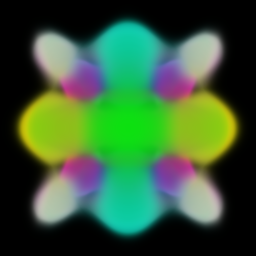

In [26]:
train(
    dummy_nerf,
    dev,
    make_video_frames(dummy, dev, 16, res=(1024, 1024), distance=distance),
    camera=Camera(),
    max_distance=2.0 * distance,
    step_size=0.05,
    batch_size=64 * 1024,
    n_epochs=20,
    lr=1e-2,
)

In [27]:
make_video("dummy_nerf", dummy_nerf, dev, (256, 256), distance, period=4.0)

100%|██████████| 96/96 [00:18<00:00,  5.08it/s]


Moviepy - Building video rendered/dummy_nerf.mp4.
Moviepy - Writing video rendered/dummy_nerf.mp4



Moviepy - Done !
Moviepy - video ready rendered/dummy_nerf.mp4


In [21]:
from pathlib import Path
import json


class Scene:
    def __init__(self, path: Path):
        with open(path / "transforms.json", "r") as f:
            transforms = json.load(f)

        self.shape = (transforms["w"], transforms["h"])
        self.camera = Camera(
            angles = (transforms["camera_angle_x"], transforms["camera_angle_y"]),
            # offset = 
            # (
            #     2.0 * transforms["cx"] / transforms["w"] - 1.0,
            #     -2.0 * transforms["cy"] / transforms["h"] + 1.0,
            # ),
        )

        self.frames: list[Frame] = []
        for frame in transforms["frames"]:
            image_path = path / frame["file_path"]
            if image_path.exists():
                self.frames.append(
                    Frame(
                        image=Image.open(image_path),
                        matrix=frame["transform_matrix"],
                    ),
                )


scene = Scene(Path("assets/fox"))

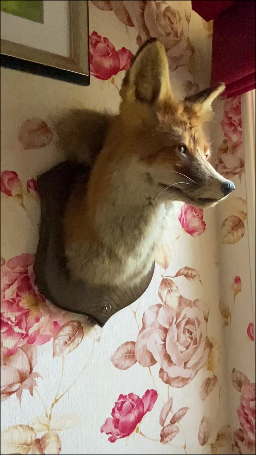

In [22]:
shape = (256, int(256 * (scene.shape[1] / scene.shape[0])))
tensor_to_image(
    sample_image(
        scene.frames[0].image_tensor(dev),
        grid(shape, dev).transpose(0, 1).flatten(0, 1),
    ).reshape((-1, shape[1], shape[0]))
)

In [27]:
max_distance = 4.0
nerf = Model(dim=64, n_modes=64, scale=1.0 / max_distance).to(dev)

'39: 0.009815850295126438'

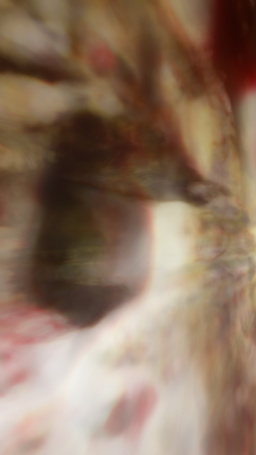

In [30]:
train(
    nerf,
    dev,
    scene.frames[:4],
    camera=scene.camera,
    max_distance=max_distance,
    step_size=0.05,
    batch_size=16 * 1024,
    n_epochs=40,
    lr=1e-3,
    test_res=shape,
)

In [ ]:
make_video("fox_nerf", nerf, dev, shape, distance, step_size=0.05, period=4.0)